In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{6}"

In [4]:
import torch
import torch.nn as nn

import numpy as np
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from torchvision import transforms
import matplotlib.pyplot as plt

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [5]:
xysize = 384
xysize_latent = 96
timesteps = 399

### Load flow data

In [6]:
Latent_data_Velocity = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/Latent_data_Velocity_{}_{}_326464.npy'.format(xysize, xysize))
Latent_data_Velocity = Latent_data_Velocity.reshape(timesteps, 32, xysize_latent, xysize_latent)
print(Latent_data_Velocity.shape)

(399, 32, 96, 96)


In [7]:
# training set
Latent_data_Velocity_training = Latent_data_Velocity[:timesteps - 50,:,:,:]

In [8]:
# test set
Latent_data_Velocity_test = Latent_data_Velocity[timesteps - 50:,:,:,:]

In [9]:
# # save training and test sets
# np.save('/home/dg321/gitTest/PRI/irp/Flow_Data/Latent_data_VelocityXs_training.npy', Latent_data_Velocity_training)
# np.save('/home/dg321/gitTest/PRI/irp/Flow_Data/Latent_data_VelocityXs_test.npy', Latent_data_Velocity_test)

### Load building data

In [10]:
Latent_data_Building = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/Latent_data_Building_{}_{}_326464.npy'.format(xysize, xysize))
Latent_data_Building = Latent_data_Building.reshape(1, 16, xysize_latent, xysize_latent)
print(Latent_data_Building.shape)

(1, 16, 96, 96)


#### Reconstruct building data

(1, 16, 96, 96)
torch.Size([16, 96, 96])
(1, 384, 384)


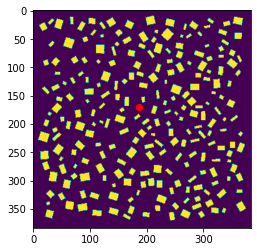

In [11]:
# Load the saved cae for building

## for building
class Autoencoder_building(nn.Module):
    def __init__(self):
        super(Autoencoder_building, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder_building = Autoencoder_building()  # Assuming you have the ConvAutoencoder class defined
autoencoder_building.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/MainCodes/models/autoencoder_Flow_Building_256_256_2000epochs.pth'))

autoencoder_building.eval()  # Set the autoencoder to evaluation mode

print(Latent_data_Building.shape)
input_data = torch.from_numpy(Latent_data_Building[0]).float()
print(input_data.shape)
res = autoencoder_building.decoder(input_data)
output_data_building = res.detach().numpy()
print(output_data_building.shape)

plt.figure()
plt.imshow(output_data_building[0])
# Plot the dot on the image
plt.scatter(186, 170, color='red', marker='o')
output_data = output_data_building

In [12]:
# Set a seed for reproducibility
np.random.seed(42)

# Get the indices of 0 values
sensors_indices = np.argwhere(output_data <= 0.00001)

# Number of points to randomly select
num_points_to_select = 10

# Randomly select indices
selected_indices = sensors_indices[np.random.choice(len(sensors_indices), size=num_points_to_select, replace=False)]

# Print the selected indices
print("Selected Indices:")
print(selected_indices)

Selected Indices:
[[  0 185 318]
 [  0 338  50]
 [  0 254 158]
 [  0 281 159]
 [  0 283  24]
 [  0 378 304]
 [  0 289 291]
 [  0 286 275]
 [  0  65 170]
 [  0 119  85]]


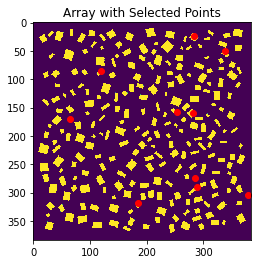

In [13]:
# Visualize the array and selected points
plt.imshow(output_data[0], interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[:, 1], selected_indices[:, 2], color='red', marker='o')

plt.title('Array with Selected Points')
plt.show()


#### Create sensors

In [14]:
sensors_x = selected_indices[:, 1]
sensors_y = selected_indices[:, 2]

### Combine Velocity and Building

In [15]:
n_sampels = 200
t_gaps_sampels = 1  ## 10 used to train the model
dt = 5
ntimes = 3

batch_size = 16  # Choose your desired batch size

samples_training = []
samples_training_X = []
samples_training_Y = []

for i in range(1, n_sampels+1):
    ii = 1 + i*t_gaps_sampels
    # s = np.concatenate([Latent_data_VelocityXs_training[ss] for ss in range(ii,ii + dt*ntimes, dt )], axis = 0)
    s = np.stack([Latent_data_Velocity_training[ss] for ss in range(ii,ii + dt*ntimes, dt )])
    s_building = Latent_data_Building
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X
    ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s[2].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X

    # ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y
    ss_1 = ss_0


    ss = (ss_0, ss_1)
    print(ss[0].shape)
    print(ss[1].shape)
    samples_training.append(ss)
    samples_training_X.append(ss_0)
    samples_training_Y.append(ss_1)

(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 9

In [16]:
samples_training_X_stacked = (np.stack(samples_training_X)).reshape(n_sampels, ss_0.shape[1], xysize_latent, xysize_latent)
print(samples_training_X_stacked.shape)

(200, 112, 96, 96)


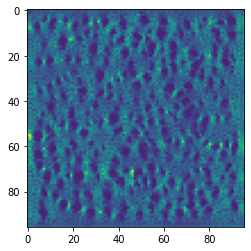

In [17]:
plt.imshow(samples_training_X_stacked[0][0])

In [18]:
samples_training_Y_stacked = (np.stack(samples_training_Y)).reshape(n_sampels, ss_1.shape[1], xysize_latent, xysize_latent)
print(samples_training_Y_stacked.shape)

(200, 112, 96, 96)


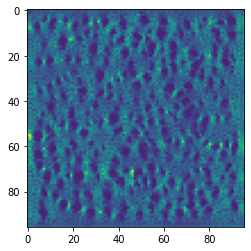

In [19]:
plt.imshow(samples_training_Y_stacked[0][0])

(array([798421., 206687.,  14655.,   3982.,   1611.,   1888.,   1603.,
          1315.,   1194.,    836.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

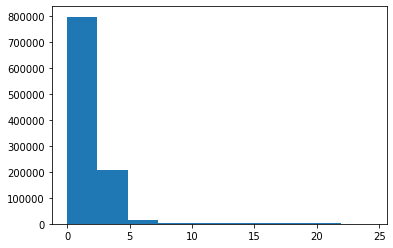

In [20]:
plt.hist(samples_training_X_stacked[0].flatten())

(array([59043., 68729.,  7610.,  3635.,  1603.,  1888.,  1603.,  1315.,
         1194.,   836.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

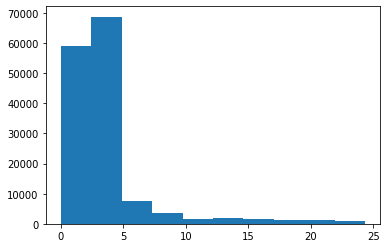

In [21]:
plt.hist(Latent_data_Building.flatten())

## Create data loader

In [22]:
data = samples_training
print(len(data))

200


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        sample = {'input': self.data_x[idx], 'target': self.data_y[idx]}
        return sample

# Create an instance of your custom dataset
my_dataset = MyDataset(samples_training_X_stacked, samples_training_Y_stacked)

# Create a DataLoader for batching and shuffling the data

shuffle = True  # Set to True if you want to shuffle the data during training

data_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=shuffle)


## Define the model

### AAE

In [22]:
# Encoder and Decoder (same as before)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # Add more convolutional layers as needed
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, ss_1.shape[1], kernel_size=5, stride=1, padding=2),
            nn.Identity(),
            # Add more convolutional layers as needed
        )

    def forward(self, x):
        return self.decoder(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

# Adversarial Autoencoder (AAE)
class AdversarialAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return decoded, discriminated


### AAE from Ventilation

In [23]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 256, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=1, padding=1, output_padding=0, bias=False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, ss_1.shape[1], kernel_size=(3, 3), stride=1, padding=1, output_padding=0, bias=False),
            nn.Identity()
        )

    def forward(self, x):
        return self.model(x)

# class DiscriminatorAAE(nn.Module):
#     def __init__(self, latent_dim):
#         super(DiscriminatorAAE, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(latent_dim, 256, bias=True),
#             nn.ReLU(),
#             nn.Linear(256, 128, bias=True),
#             nn.ReLU(),
#             nn.Linear(128, 64, bias=True),
#             nn.ReLU(),
#             nn.Linear(64, 1, bias=True)
#         )

#     def forward(self, x):
#         return self.model(x)
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)
    
# Adversarial Autoencoder (AAE)
class AdversarialAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return decoded, discriminated

# # Instantiate the PyTorch models
# encoder_aae1 = Encoder()
# decoder_aae1 = Decoder()
# discriminator_aae = Discriminator()

## Train model

In [24]:
# Instantiate components and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)
aae_model = AdversarialAutoencoder(encoder, decoder, discriminator).to(device)

# Loss functions
reconstruction_loss_fn = nn.MSELoss()
adversarial_loss_fn = nn.BCELoss()

# Optimizers
lr_ae = 0.001
lr_d = 0.001

optimizer_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr_ae)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d)

In [25]:
num_epochs = 100

# Lists to store losses for plotting
all_losses_ae = []
all_losses_d = []

# Print the GPU device
print(f"Running on GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
# Training loop
for epoch in range(num_epochs):
    epoch_losses_ae = []
    epoch_losses_d = []

    for batch in data_loader:
        inputs, targets = batch['input'].to(device), batch['target'].to(device)

        # Train autoencoder
        optimizer_ae.zero_grad()
        decoded, discriminated = aae_model(inputs)
        loss_ae = reconstruction_loss_fn(decoded, targets)
        loss_ae.backward()
        optimizer_ae.step()
        epoch_losses_ae.append(loss_ae.item())

        # Train discriminator
        optimizer_d.zero_grad()
        with torch.no_grad():
            encoded_fake = encoder(inputs).detach()
            encoded_true = torch.randn_like(encoded_fake).to(device)   # the true sample
        fake_output = discriminator(encoded_fake)
        true_output = discriminator(encoded_true)
        loss_d = adversarial_loss_fn(fake_output, torch.zeros_like(fake_output).to(device)) + \
                 adversarial_loss_fn(true_output, torch.ones_like(true_output).to(device))
        loss_d.backward()
        optimizer_d.step()
        epoch_losses_d.append(loss_d.item())

    # Average losses over the epoch
    avg_loss_ae = sum(epoch_losses_ae) / len(epoch_losses_ae)
    avg_loss_d = sum(epoch_losses_d) / len(epoch_losses_d)

    # Print the average loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], AE Loss: {avg_loss_ae:.4f}, D Loss: {avg_loss_d:.4f}')

    # Record the losses for plotting
    all_losses_ae.append(avg_loss_ae)
    all_losses_d.append(avg_loss_d)

# Plot the losses separately
plt.figure(figsize=(10, 5))

# Autoencoder Loss Plot
plt.subplot(1, 2, 1)
plt.plot(all_losses_ae, label='Autoencoder Loss')
plt.title('Autoencoder Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Discriminator Loss Plot
plt.subplot(1, 2, 2)
plt.plot(all_losses_d, label='Discriminator Loss', color='orange')
plt.title('Discriminator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished.")
aae_model = aae_model.cpu()
print("Moved model back to cpu.")

Running on GPU: GeForce RTX 2080 Ti
Epoch [1/100], AE Loss: 9.4073, D Loss: 1.3226
Epoch [2/100], AE Loss: 3.0479, D Loss: 1.1394
Epoch [3/100], AE Loss: 2.5861, D Loss: 0.9601
Epoch [4/100], AE Loss: 2.3246, D Loss: 0.8032
Epoch [5/100], AE Loss: 1.7500, D Loss: 0.6760
Epoch [6/100], AE Loss: 1.4345, D Loss: 0.5616
Epoch [7/100], AE Loss: 1.1968, D Loss: 0.4768
Epoch [8/100], AE Loss: 1.0157, D Loss: 0.4131
Epoch [9/100], AE Loss: 0.8655, D Loss: 0.3499
Epoch [10/100], AE Loss: 0.7822, D Loss: 0.2999
Epoch [11/100], AE Loss: 0.6874, D Loss: 0.2515
Epoch [12/100], AE Loss: 0.6356, D Loss: 0.2159
Epoch [13/100], AE Loss: 0.5774, D Loss: 0.1935
Epoch [14/100], AE Loss: 0.5482, D Loss: 0.1663
Epoch [15/100], AE Loss: 0.4825, D Loss: 0.1512
Epoch [16/100], AE Loss: 0.4585, D Loss: 0.1435
Epoch [17/100], AE Loss: 0.4203, D Loss: 0.1202
Epoch [18/100], AE Loss: 0.3986, D Loss: 0.1051
Epoch [19/100], AE Loss: 0.3812, D Loss: 0.0948
Epoch [20/100], AE Loss: 0.3643, D Loss: 0.0833
Epoch [21/100

KeyboardInterrupt: 

### Save trained model

In [57]:
torch.save(aae_model.state_dict(), '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_{}epochs_{}batchsize_addBuilding_newoutputshape.pth'.format(num_epochs, batch_size))  ### PredictionMulti

## Load saved model - AE

In [24]:
# Load the saved autoencoder
autoencoderP = MyModel()  # Assuming you have the ConvAutoencoder class defined
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_64batchsize_lr0.003_updatedLoss.pth'))
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_32batchsize_lr0.003_updatedLoss.pth'))
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_64batchsize_lr0.003_updatedLoss.pth'))
autoencoderP.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_8000epochs_AE80Samples_3ts.pth'))

autoencoderP.eval()  # Set the autoencoder to evaluation mode

MyModel(
  (encoder): Sequential(
    (0): Conv2d(112, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): Identity()
  )
)

## Load saved model - AAE

In [23]:
num_epochs = 100
batch_size = 1


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 256, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=1, padding=1, output_padding=0, bias=False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, ss_1.shape[1], kernel_size=(3, 3), stride=1, padding=1, output_padding=0, bias=False),
            nn.Identity()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)
    
# Adversarial Autoencoder (AAE)
class AdversarialAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return decoded, discriminated

# Load the saved autoencoder
# Instantiate components
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()
autoencoderP = AdversarialAutoencoder(encoder, decoder, discriminator)

autoencoderP.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_{}epochs_{}batchsize_addBuilding_newoutputshape.pth'.format(num_epochs, batch_size)))

autoencoderP.eval()  # Set the autoencoder to evaluation mode

AdversarialAutoencoder(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv2d(112, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): Decoder(
    (model): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): ConvTranspose2d(64, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): Identity()
    )
  )
  (discriminator): Discriminator(
    (discriminator): Sequential(
      (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

## Generate result plots

### Load CAE model

In [24]:
## for velocity
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Identity()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load the saved autoencoder
autoencoder = Autoencoder()  # Assuming you have the ConvAutoencoder class defined
autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/MainCodes/models/Velocity256_Compression_1500epochs_32batchsize_lr0.001_326464.pth'))

autoencoder.eval()  # Set the autoencoder to evaluation mode

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(2, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 2, kernel_size=(2, 2), stride=(2, 2))
    (3): Identity()
  )
)

In [25]:
sample = samples_training_Y_stacked[1]
print(sample.shape)

(112, 96, 96)


In [26]:
input_data = torch.from_numpy(sample[:32,:,:]).unsqueeze(0).float()
print(input_data.shape)
res = autoencoder.decoder(input_data)
output_data = res.detach().numpy()
print(output_data.shape)

torch.Size([1, 32, 96, 96])
(1, 2, 384, 384)


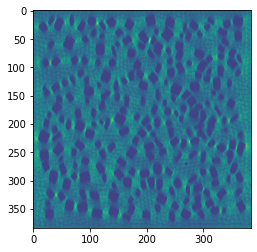

In [27]:
plt.figure()
plt.imshow(output_data[0,0])

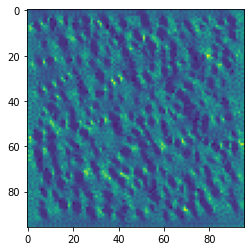

In [27]:
plt.imshow(samples_training_Y_stacked[0][16])

### Predict

In [33]:
id = 1
sampleX = torch.from_numpy((samples_training_X_stacked[id]).reshape(1,ss_0.shape[1],xysize_latent,xysize_latent)).float()
sampleTarget = torch.from_numpy((samples_training_Y_stacked[id]).reshape(1,ss_1.shape[1],xysize_latent,xysize_latent)).float()
print(sampleX.shape)
print(sampleTarget.shape)

torch.Size([1, 112, 96, 96])
torch.Size([1, 112, 96, 96])


In [34]:
with torch.no_grad():
    aae_model.eval().cpu()  # Set the model to evaluation mode
    prediction = aae_model(sampleX)

prediction = prediction[0]

torch.Size([1, 112, 96, 96])


(array([792089., 212227.,  15377.,   4047.,   1616.,   1888.,   1603.,
          1315.,   1194.,    836.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

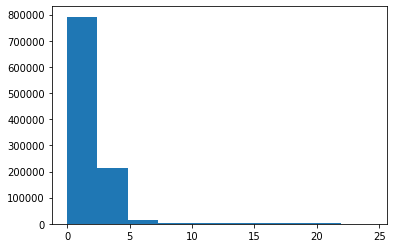

In [35]:
print(sampleTarget.shape)
plt.hist(sampleTarget.flatten())

torch.Size([1, 112, 96, 96])


(array([5.64958e+05, 4.07719e+05, 4.66570e+04, 4.70000e+03, 1.69200e+03,
        1.78300e+03, 1.62900e+03, 1.53600e+03, 1.16000e+03, 3.58000e+02]),
 array([-1.064398 ,  1.5832101,  4.2308183,  6.8784266,  9.526034 ,
        12.173643 , 14.821251 , 17.468859 , 20.116468 , 22.764076 ,
        25.411684 ], dtype=float32),
 <BarContainer object of 10 artists>)

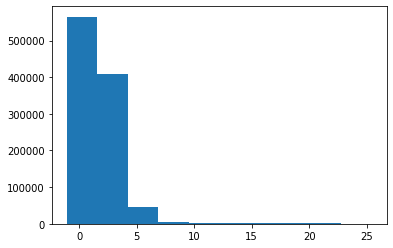

In [36]:
print(prediction.shape)
plt.hist(prediction.flatten())

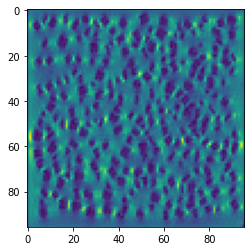

In [37]:
plt.imshow(prediction[0][4])

torch.Size([1, 32, 96, 96])
(1, 2, 384, 384)


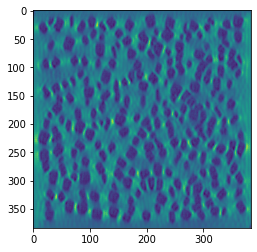

In [38]:
# input_data = torch.from_numpy(prediction).unsqueeze(0).float()
# input_data = prediction[:1, :, :, :]
input_data = prediction[:1, 64:96, :, :]
print(input_data.shape)
res = autoencoder.decoder(input_data)
output_data = res.detach().numpy()
print(output_data.shape)
plt.figure()
plt.imshow(output_data[0,0])

In [30]:
def mse_loss(image1, image2):
    """
    Compute the Mean Squared Error (MSE) loss between two images.

    Parameters:
        - image1: NumPy array representing the first image
        - image2: NumPy array representing the second image

    Returns:
        - mse: MSE loss value
    """
    mse = np.mean((image1 - image2)**2)
    return mse


In [40]:
# Plot the results together

def plot_results_together(id_sample):
    velocity_field = 0

    sampleX = samples_training_X_stacked[id_sample]
    sampleY = samples_training_Y_stacked[id_sample]


    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32+32:32+32+32,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    # switch models here
    # prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
    prediction = aae_model(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, 64:96, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(1,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[0].title.set_text('X1')

    # sub12 = axarr[1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1].title.set_text('X2')

    # sub13 = axarr[2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[2].title.set_text('Y_Target')

    # sub14 = axarr[3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[3].title.set_text('Y_Prediction')

In [41]:
for i in range(1,60,1):
    plot_results_together(i)

prediction error: 0.04364145
prediction error: 0.043900207
prediction error: 0.044098422
prediction error: 0.044289008
prediction error: 0.044502966
prediction error: 0.044724032
prediction error: 0.044880666
prediction error: 0.04503759
prediction error: 0.045176506
prediction error: 0.045368686
prediction error: 0.045599148
prediction error: 0.045898106
prediction error: 0.046233438
prediction error: 0.04656166
prediction error: 0.046927027
prediction error: 0.04723539
prediction error: 0.04752879
prediction error: 0.047772214
prediction error: 0.0480114
prediction error: 0.04836398
prediction error: 0.048775066
prediction error: 0.049233135
prediction error: 0.049704425
prediction error: 0.050180826
prediction error: 0.050692968
prediction error: 0.0512057
prediction error: 0.051705204
prediction error: 0.052177787
prediction error: 0.052798074
prediction error: 0.05359088
prediction error: 0.05447471
prediction error: 0.055315398
prediction error: 0.05600363
prediction error: 0.056

In [42]:
for i in range(1,60,1):
    plot_results_together(i)

prediction error: 0.04364145
prediction error: 0.043900207
prediction error: 0.044098422
prediction error: 0.044289008
prediction error: 0.044502966
prediction error: 0.044724032
prediction error: 0.044880666
prediction error: 0.04503759
prediction error: 0.045176506
prediction error: 0.045368686
prediction error: 0.045599148
prediction error: 0.045898106
prediction error: 0.046233438
prediction error: 0.04656166
prediction error: 0.046927027
prediction error: 0.04723539
prediction error: 0.04752879
prediction error: 0.047772214
prediction error: 0.0480114
prediction error: 0.04836398
prediction error: 0.048775066
prediction error: 0.049233135
prediction error: 0.049704425
prediction error: 0.050180826
prediction error: 0.050692968
prediction error: 0.0512057
prediction error: 0.051705204
prediction error: 0.052177787
prediction error: 0.052798074
prediction error: 0.05359088
prediction error: 0.05447471
prediction error: 0.055315398
prediction error: 0.05600363
prediction error: 0.056

### Predict for test

In [43]:
n_sampels = 10
t_gaps_sampels = 2
dt = 5
ntimes = 3

batch_size = 1  # Choose your desired batch size

samples_test = []
samples_test_X = []
samples_test_Y = []

for i in range(1, n_sampels+1):
    ii = 1 + i*t_gaps_sampels
    # s = np.concatenate([Latent_data_VelocityXs_test[ss] for ss in range(ii,ii + dt*ntimes, dt )], axis = 0)
    s = np.stack([Latent_data_Velocity_test[ss] for ss in range(ii,ii + dt*ntimes, dt )])
    s_building = Latent_data_Building
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X
    ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s[2].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X

    # ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y
    ss_1 = ss_0


    ss = (ss_0, ss_1)
    print(ss[0].shape)
    print(ss[1].shape)
    samples_test.append(ss)
    samples_test_X.append(ss_0)
    samples_test_Y.append(ss_1)


samples_test_X_stacked = (np.stack(samples_test_X)).reshape(n_sampels, ss_0.shape[1], xysize_latent, xysize_latent)
print(samples_test_X_stacked.shape)

samples_test_Y_stacked = (np.stack(samples_test_Y)).reshape(n_sampels, ss_1.shape[1], xysize_latent, xysize_latent)
print(samples_test_Y_stacked.shape)

(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(10, 112, 96, 96)
(10, 112, 96, 96)


In [44]:
autoencoderP = aae_model

In [47]:
# Plot the results together

def plot_results_together(id_sample, velocity_field):
    velocity_field = velocity_field

    sampleX = samples_test_X_stacked[id_sample]
    sampleY = samples_test_Y_stacked[id_sample]


    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[64:96,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    # switch models here
    # prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
    prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, 64:96, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(2,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[1][0].title.set_text('X1')

    # sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1][1].title.set_text('X2')

    # sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[1][2].title.set_text('Y_Target')

    # sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[1][3].title.set_text('Y_Prediction')

In [48]:
for i in range(1,10):
    plot_results_together(i, 1)

prediction error: 0.109089054
prediction error: 0.10987899
prediction error: 0.11049479
prediction error: 0.1109848
prediction error: 0.11064412
prediction error: 0.11083851
prediction error: 0.11074051
prediction error: 0.110810265
prediction error: 0.110778615


In [ ]:
for i in range(1,10):
    plot_results_together(i, 0)

# Predict iteratively

In [28]:
autoencoderP = aae_model

NameError: name 'aae_model' is not defined

prediction error: 0.04364145


<Figure size 432x288 with 0 Axes>

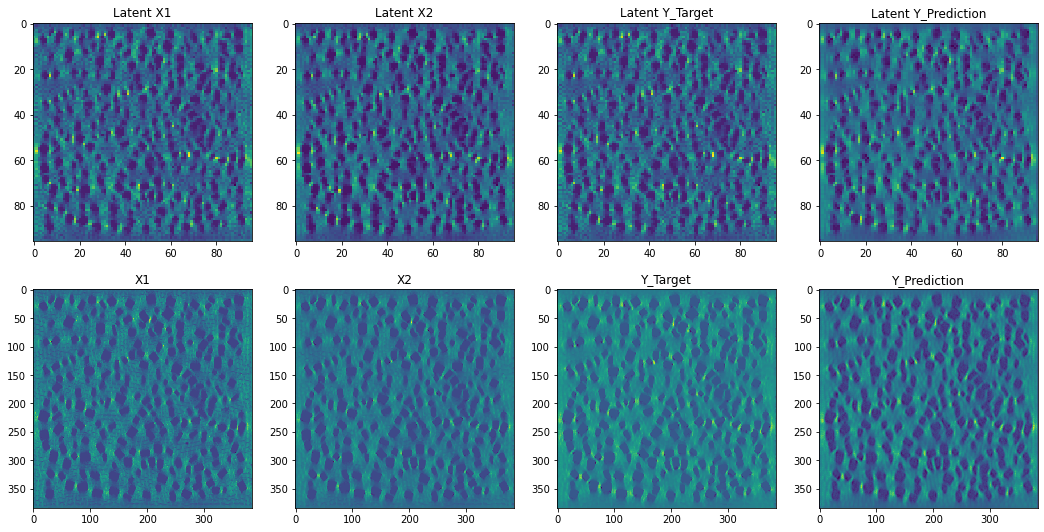

In [31]:
id_sample = 1

velocity_field = 0

sampleX = samples_training_X_stacked[id_sample]
sampleY = samples_training_Y_stacked[id_sample]


X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
X1_decoded = X1_decoded.detach().numpy()

X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
X2_decoded = X2_decoded.detach().numpy()

Y_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32+32:32+32+32,:,:]).unsqueeze(0).float())
Y_decoded = Y_decoded.detach().numpy()

prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

prediction_decoded = autoencoder.decoder(prediction[:1, 64:96, :, :])
prediction_decoded = prediction_decoded.detach().numpy()


loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
print("prediction error:", loss)


plt.figure()

f, axarr = plt.subplots(2,4, figsize=(18, 9))

# plot latent space
sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
axarr[0][0].title.set_text('Latent X1')

sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
axarr[0][1].title.set_text('Latent X2')

sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
axarr[0][2].title.set_text('Latent Y_Target')

sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
axarr[0][3].title.set_text('Latent Y_Prediction')

# plot decoded space
sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
axarr[1][0].title.set_text('X1')

sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
axarr[1][1].title.set_text('X2')

sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
axarr[1][2].title.set_text('Y_Target')

sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
axarr[1][3].title.set_text('Y_Prediction')

In [38]:
losses = []
losses_2pts_latent = []
n_iters = 50



id_sample = 1

velocity_field = 0

sampleX = samples_training_X_stacked[id_sample]
sampleY = samples_training_Y_stacked[id_sample]


X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
X1_decoded = X1_decoded.detach().numpy()

X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
X2_decoded = X2_decoded.detach().numpy()

Y_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32+32:32+32+32,:,:]).unsqueeze(0).float())
Y_decoded = Y_decoded.detach().numpy()

sampleX[32+32:32+32+32,:,:] = sampleX[32:32+32,:,:]
prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

prediction_decoded = autoencoder.decoder(prediction[:1, 64:96, :, :])
prediction_decoded = prediction_decoded.detach().numpy()


loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
print("prediction error:", loss)
losses.append(loss)

loss_2pts_latent = mse_loss(prediction[:1, :64, :, :].detach().numpy(), sampleX[:64,:,:])
losses_2pts_latent.append(loss_2pts_latent)

# plt.figure()

# f, axarr = plt.subplots(2,4, figsize=(18, 9))

# # plot latent space
# sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
# axarr[0][0].title.set_text('Latent X1')

# sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
# axarr[0][1].title.set_text('Latent X2')

# sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
# axarr[0][2].title.set_text('Latent Y_Target')

# sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
# axarr[0][3].title.set_text('Latent Y_Prediction')

# # plot decoded space
# sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
# axarr[1][0].title.set_text('X1')

# sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
# axarr[1][1].title.set_text('X2')

# sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
# axarr[1][2].title.set_text('Y_Target')

# sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
# axarr[1][3].title.set_text('Y_Prediction')

prediction_new = prediction


for i in range(n_iters):

    sampleX = samples_training_X_stacked[id_sample]
    sampleX_new = sampleX.copy()
    prediction = prediction_new.detach().numpy()
    sampleX_new[64:64+32] = prediction[0,64:64+32]

    prediction_new = autoencoderP(torch.from_numpy(sampleX_new).unsqueeze(0).float())[0]

    prediction_decoded = autoencoder.decoder(prediction_new[:1, 64:64+32, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()

    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)
    losses.append(loss)

    loss_2pts_latent = mse_loss(prediction_new[:1, :64, :, :].detach().numpy(), sampleX[:64,:,:])
    losses_2pts_latent.append(loss_2pts_latent)

    # plt.figure()

    # f, axarr = plt.subplots(2,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleX_new[64], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction_new.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[1][0].title.set_text('X1')

    # sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1][1].title.set_text('X2')

    # sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[1][2].title.set_text('Y_Target')

    # sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[1][3].title.set_text('Y_Prediction')

prediction error: 0.039385088
prediction error: 0.04842274
prediction error: 0.054398045
prediction error: 0.058666427
prediction error: 0.061789412
prediction error: 0.06408504
prediction error: 0.06577119
prediction error: 0.06700849
prediction error: 0.06791692
prediction error: 0.06858521
prediction error: 0.06907761
prediction error: 0.06944106
prediction error: 0.06970979
prediction error: 0.0699089
prediction error: 0.070056714
prediction error: 0.07016671
prediction error: 0.07024871
prediction error: 0.07031003
prediction error: 0.07035595
prediction error: 0.0703904
prediction error: 0.07041632
prediction error: 0.07043584
prediction error: 0.07045055
prediction error: 0.07046166
prediction error: 0.070470095
prediction error: 0.07047646
prediction error: 0.0704813
prediction error: 0.07048499
prediction error: 0.07048777
prediction error: 0.07048991
prediction error: 0.07049152
prediction error: 0.07049277
prediction error: 0.07049373
prediction error: 0.07049444
prediction 

In [33]:
print(len(losses))

51


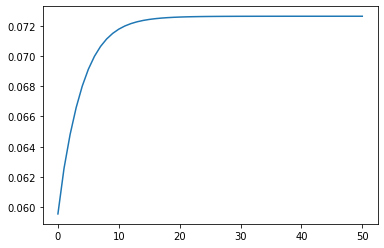

In [34]:
plt.plot(losses[:])

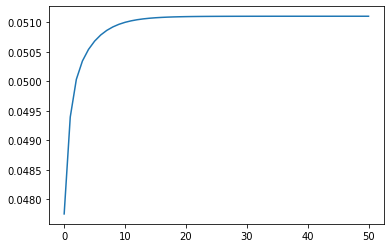

In [39]:
plt.plot(losses_2pts_latent[:])

# Time stepping - predict forward in time

In [28]:
def mse_loss(image1, image2):
    """
    Compute the Mean Squared Error (MSE) loss between two images.

    Parameters:
        - image1: NumPy array representing the first image
        - image2: NumPy array representing the second image

    Returns:
        - mse: MSE loss value
    """
    mse = np.mean((image1 - image2)**2)
    return mse


In [46]:
def run_iteration(sample_input, n_iters=25):

    SampleX = sample_input.clone()

    losses_2pts_latent = []

    prediction = autoencoderP(SampleX.float())[0]

    loss_2pts_latent = mse_loss(prediction[:1, :64, :, :].detach().numpy(), SampleX[:1, :64, :, :].detach().numpy())
    losses_2pts_latent.append(loss_2pts_latent)

    prediction_new = prediction

    for i in range(n_iters):
        sampleX_new = sample_input.clone()
        prediction = prediction_new
        # print(sampleX_new.shape)
        # print(prediction.shape)
        sampleX_new[0, 64:64 + 32] = prediction[0, 64:64 + 32]

        prediction_new = autoencoderP(sampleX_new.float())[0]
    
        loss_2pts_latent = mse_loss(prediction_new[:1, :64, :, :].detach().numpy(), SampleX[:1, :64, :, :].detach().numpy())
        losses_2pts_latent.append(loss_2pts_latent)

    return prediction_new, losses_2pts_latent

prediction error: 0.07261966
prediction error: 0.1696165
prediction error: 0.25598466
prediction error: 0.34343782
prediction error: 0.42898118
prediction error: 0.5129923
prediction error: 0.6022436
prediction error: 0.6998027
prediction error: 0.8066612
prediction error: 0.9271449
prediction error: 1.0710166


<Figure size 432x288 with 0 Axes>

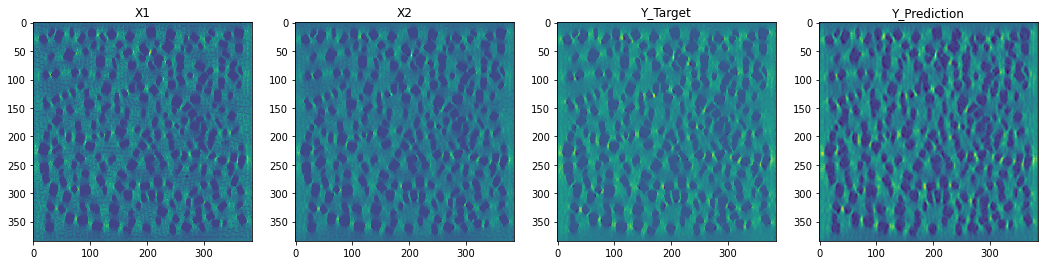

In [48]:
# can change run_iteration to autoencoderP

num_time_stepping = 10
velocity_field = 0
id_sample = 1

Samples_Ytargets = []
Samples_Predictions = []

sensor_values_X1 = []
sensor_values_X2 = []
sensor_values_Ytarget = []
sensor_values_prediction = []

timelevels = []

sampleX = samples_training_X_stacked[id_sample]
sampleY = samples_training_X_stacked[id_sample]


X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
X1_decoded = X1_decoded.detach().numpy()

X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
X2_decoded = X2_decoded.detach().numpy()

Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[32+32:32+32+32,:,:]).unsqueeze(0).float())
Y_decoded = Y_decoded.detach().numpy()

prediction = run_iteration(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

prediction_decoded = autoencoder.decoder(prediction[:1, 32+32:32+32+32, :, :])
prediction_decoded = prediction_decoded.detach().numpy()


Samples_Ytargets.append(Y_decoded)
Samples_Predictions.append(prediction_decoded)

# get sensor data
sensor_values_prediction.append(prediction_decoded[0,velocity_field, sensors_x, sensors_y])
sensor_values_X1.append(X1_decoded[0,velocity_field, sensors_x, sensors_y])
sensor_values_X2.append(X2_decoded[0,velocity_field, sensors_x, sensors_y])
sensor_values_Ytarget.append(Y_decoded[0,velocity_field, sensors_x, sensors_y])

loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
print("prediction error:", loss)

timelevel = id_sample*t_gaps_sampels + dt*2 # for training

timelevels.append(timelevel)

plt.figure()

f, axarr = plt.subplots(1,4, figsize=(18, 9))

# plot latent space
# sub1 = axarr[0].imshow(sampleX[0], interpolation='none')
# axarr[0].title.set_text('Latent X1')

# sub2 = axarr[1].imshow(sampleX[32], interpolation='none')
# axarr[1].title.set_text('Latent X2')

# sub3 = axarr[2].imshow(sampleY[0], interpolation='none')
# axarr[2].title.set_text('Latent Y_Target')

# sub4 = axarr[3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
# axarr[3].title.set_text('Latent Y_Prediction')

# plot decoded space
sub11 = axarr[0].imshow(X1_decoded[0][velocity_field], interpolation='none')
axarr[0].title.set_text('X1')

sub12 = axarr[1].imshow(X2_decoded[0][velocity_field], interpolation='none')
axarr[1].title.set_text('X2')

sub13 = axarr[2].imshow(Y_decoded[0][velocity_field], interpolation='none')
axarr[2].title.set_text('Y_Target')

sub14 = axarr[3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
axarr[3].title.set_text('Y_Prediction')


for n in range(num_time_stepping):    
    sampleX_new = sampleX.copy()
    sampleX_new[:32] = sampleX[32:64]
    sampleX_new[32:64] = (prediction.detach().numpy())[0, 64:96]
    sampleX_new[64:96] = sampleX_new[32:64]

    sampleY_new = Latent_data_Velocity_training[1 + id_sample*t_gaps_sampels + dt*(4 + n)]

    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX_new[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX_new[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY_new[:,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    prediction = run_iteration(torch.from_numpy(sampleX_new).unsqueeze(0).float())[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, 64:96, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()
    
    Samples_Ytargets.append(Y_decoded)
    Samples_Predictions.append(prediction_decoded)

    # get sensor data
    sensor_values_prediction.append(prediction_decoded[0,velocity_field, sensors_x, sensors_y])
    sensor_values_X1.append(X1_decoded[0,velocity_field, sensors_x, sensors_y])
    sensor_values_X2.append(X2_decoded[0,velocity_field, sensors_x, sensors_y])
    sensor_values_Ytarget.append(Y_decoded[0,velocity_field, sensors_x, sensors_y])

    timelevel = timelevel + dt
    timelevels.append(timelevel)


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(1,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0].imshow(sampleX_new[0], interpolation='none')
    # axarr[0].title.set_text('Latent X1')

    # sub2 = axarr[1].imshow(sampleX_new[32], interpolation='none')
    # axarr[1].title.set_text('Latent X2')

    # sub3 = axarr[2].imshow(sampleY_new[0], interpolation='none')
    # axarr[2].title.set_text('Latent Y_Target')

    # sub4 = axarr[3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[3].title.set_text('Latent Y_Prediction')

    # plot decoded space
    # sub11 = axarr[0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[0].title.set_text('X1')

    # sub12 = axarr[1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1].title.set_text('X2')

    # sub13 = axarr[2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[2].title.set_text('Y_Target')

    # sub14 = axarr[3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[3].title.set_text('Y_Prediction')


    sampleX = sampleX_new.copy()

In [49]:
print(len(Samples_Ytargets))
print(len(Samples_Predictions))

print(len(sensor_values_prediction))
print(len(sensor_values_X1))
print(len(sensor_values_X2))
print(len(sensor_values_Ytarget))
print(len(timelevels))

11
11
11
11
11
11
11


In [54]:
print(Samples_Predictions[0].shape)
print(Samples_Ytargets[0].shape)

numpy_array_Samples_Predictions = np.squeeze(np.stack(Samples_Predictions), axis = 1)
numpy_array_Samples_Ytargets = np.squeeze(np.stack(Samples_Ytargets), axis = 1)

print(numpy_array_Samples_Predictions.shape)
print(numpy_array_Samples_Ytargets.shape)

(1, 2, 384, 384)
(1, 2, 384, 384)
(11, 2, 384, 384)
(11, 2, 384, 384)


In [42]:
numpy_array_prediction = np.array(sensor_values_prediction)
numpy_array_X1 = np.array(sensor_values_X1)
numpy_array_X2 = np.array(sensor_values_X2)
numpy_array_Ytarget = np.array(sensor_values_Ytarget)
numpy_array_timelevels = np.array(timelevels)

# Print the shape of each NumPy array
print("Shape of numpy_array_prediction:", numpy_array_prediction.shape)
print("Shape of numpy_array_X1:", numpy_array_X1.shape)
print("Shape of numpy_array_X2:", numpy_array_X2.shape)
print("Shape of numpy_array_Ytarget:", numpy_array_Ytarget.shape)
print("Shape of numpy_array_timelevels:", numpy_array_timelevels.shape)

Shape of numpy_array_prediction: (11, 10)
Shape of numpy_array_X1: (11, 10)
Shape of numpy_array_X2: (11, 10)
Shape of numpy_array_Ytarget: (11, 10)
Shape of numpy_array_timelevels: (11,)


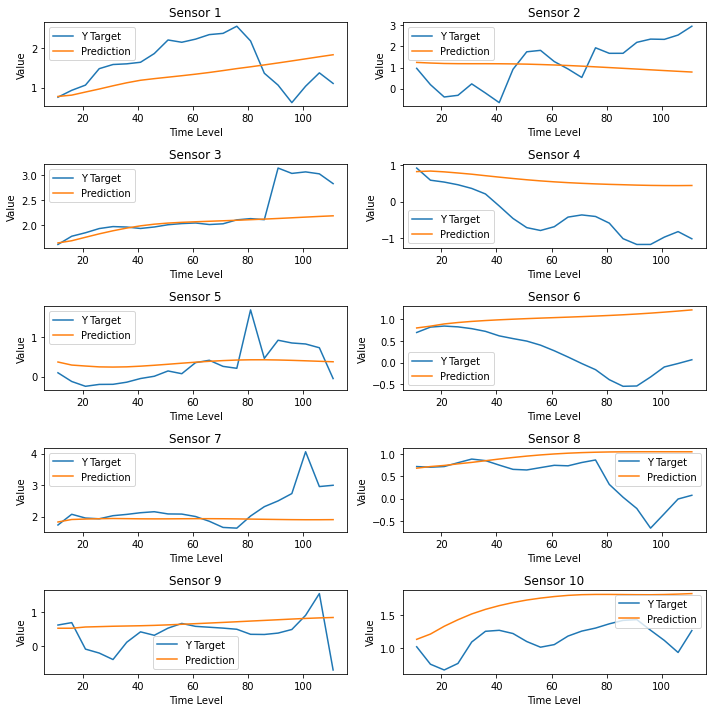

In [67]:
# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i]
    prediction_sample = numpy_array_prediction[:, i]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].plot(numpy_array_timelevels, y_target_sample, label='Y Target')
    axs[row, col].plot(numpy_array_timelevels, prediction_sample, label='Prediction')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Time Level')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

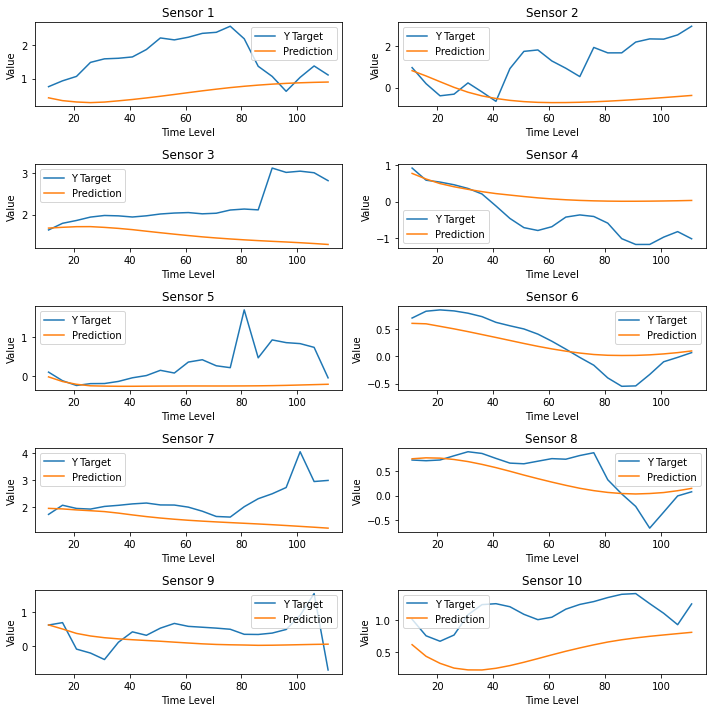

In [62]:
# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i]
    prediction_sample = numpy_array_prediction[:, i]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].plot(numpy_array_timelevels, y_target_sample, label='Y Target')
    axs[row, col].plot(numpy_array_timelevels, prediction_sample, label='Prediction')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Time Level')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

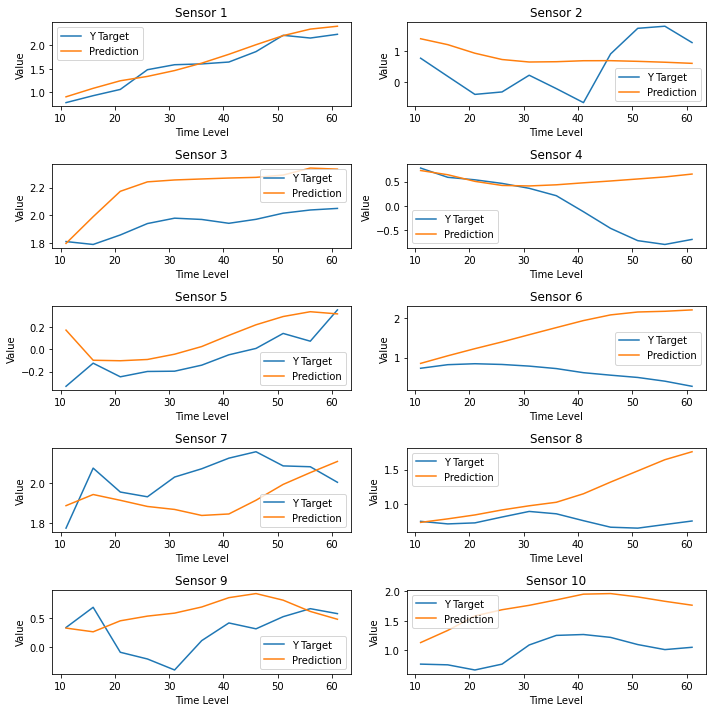

In [43]:
# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i]
    prediction_sample = numpy_array_prediction[:, i]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].plot(numpy_array_timelevels, y_target_sample, label='Y Target')
    axs[row, col].plot(numpy_array_timelevels, prediction_sample, label='Prediction')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Time Level')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

### calculate DFT/FFT

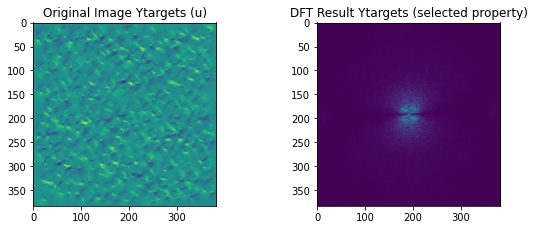

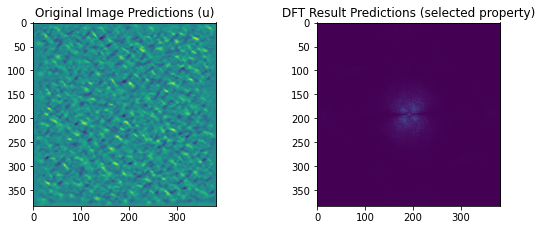

In [64]:
# Function to calculate DFT for each sample in an array
def calculate_dft_for_each_sample(data):
    # Calculate 2D Fourier Transform along the last two dimensions
    dft_result = np.fft.fft2(data, axes=(-2, -1))
    return dft_result

# Function to plot original images and DFT results for a specific property
def plot_images_and_dft(data, dft_result, property_index, title_prefix):
    plt.figure(figsize=(12, 6))

    # Plot original images
    plt.subplot(231)
    plt.imshow(data[sample_index, property_index], cmap='viridis')
    plt.title(f'Original Image {title_prefix} (u)')

    # Plot DFT results
    plt.subplot(232)
    plt.imshow(np.abs(np.fft.fftshift(dft_result[sample_index, property_index])), cmap='viridis')
    plt.title(f'DFT Result {title_prefix} (selected property)')

    plt.tight_layout()
    plt.show()

# Calculate DFT for each sample in both arrays
dft_result_Ytargets = calculate_dft_for_each_sample(numpy_array_Samples_Ytargets)
dft_result_Predictions = calculate_dft_for_each_sample(numpy_array_Samples_Predictions)

# Display the original images and their DFT results for the first sample
sample_index = 2

# Choose which property to plot (0 for u, 1 for v)
property_index_to_plot = 1

# Plot for Ytargets
plot_images_and_dft(numpy_array_Samples_Ytargets, dft_result_Ytargets, property_index_to_plot, 'Ytargets')

# Plot for Predictions
plot_images_and_dft(numpy_array_Samples_Predictions, dft_result_Predictions, property_index_to_plot, 'Predictions')
